In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
train_dataset = datasets.MNIST(root='./files/mnist_data/', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./files/mnist_data/', train=False, download=True, transform=transforms.ToTensor())

In [9]:
kwargs = {'num_workers': 1, 'pin_memory': True}
train_loader = DataLoader(dataset=train_dataset, batch_size = 128, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=test_dataset, batch_size = 128, shuffle=True, **kwargs)

In [4]:
# Set random seeds

torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class VAE(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.encoder = nn.Sequential(
            nn.Linear(784, self.d ** 2),
            nn.ReLU(),
            nn.Linear(self.d ** 2, self.d * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.d, self.d ** 2),
            nn.ReLU(),
            nn.Linear(self.d**2, 784),
            nn.Sigmoid()
        )
    
    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def forward(self, x):
        mu_log_var = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_log_var[:, 0, :]
        log_var = mu_log_var[:, 1, :]
        z = self.reparameterise(mu, log_var)
        return self.decoder(z), mu, log_var

model = VAE(20).to(device)

In [15]:
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [16]:
def loss(x_hat, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(x_hat, x.view(-1, 784), reduction='sum')
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    return BCE + beta * KLD

In [17]:
epochs = 20
for epoch in range(epochs):
    model.train()
    lossval = 0
    for x,_ in train_loader:
        #forward
        x = x.to(device)
        x_hat, mu, logvar = model(x)
        trainloss = loss(x_hat, x, mu, logvar)
        lossval += trainloss.item()
        #backward
        optimizer.zero_grad()
        trainloss.backward()
        optimizer.step()
    print(f"Epoch ---> {epoch} ----Train Loss Avg ----> {lossval / len(train_loader.dataset):.4f}")
    testlossval = 0
    with torch.no_grad():
        model.eval()
        for x,_ in test_loader:
            #forward
            x = x.to(device)
            x_hat, mu, logvar = model(x)
            testloss = loss(x_hat, x, mu, logvar)
            testlossval += testloss.item()
    print(f"Epoch ---> {epoch} ----Test Loss Avg ----> {testlossval/ len(test_loader.dataset):.4f}")
    print("--------------------------------------------------------------------")
    
            

Epoch ---> 0 ----Train Loss Avg ----> 164.7892
Epoch ---> 0 ----Test Loss Avg ----> 120.4599
--------------------------------------------------------------------
Epoch ---> 1 ----Train Loss Avg ----> 121.5174
Epoch ---> 1 ----Test Loss Avg ----> 107.0416
--------------------------------------------------------------------
Epoch ---> 2 ----Train Loss Avg ----> 114.6050
Epoch ---> 2 ----Test Loss Avg ----> 103.8228
--------------------------------------------------------------------
Epoch ---> 3 ----Train Loss Avg ----> 111.5774
Epoch ---> 3 ----Test Loss Avg ----> 101.4135
--------------------------------------------------------------------
Epoch ---> 4 ----Train Loss Avg ----> 109.9096
Epoch ---> 4 ----Test Loss Avg ----> 99.5306
--------------------------------------------------------------------
Epoch ---> 5 ----Train Loss Avg ----> 108.6982
Epoch ---> 5 ----Test Loss Avg ----> 98.7006
--------------------------------------------------------------------
Epoch ---> 6 ----Train Loss Av

In [59]:
N = 5
z = torch.randn((N,20)).to(device)
result = model.decoder(z)

In [60]:
generated = result.data.cpu().view(-1,28,28)

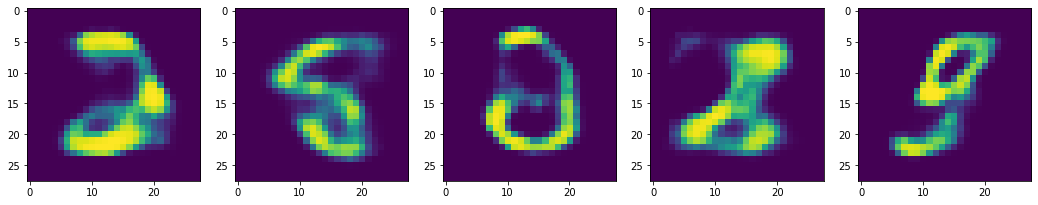

In [61]:
plt.figure(figsize=(18,15))
for i,img in enumerate(generated):
    plt.subplot(1,5,i+1)
    plt.imshow(img, interpolation='nearest')
